In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(here)
library(furrr)
library(cowplot)
library(glue)
library(lemon)
library(rtracklayer)
library(scales)
})

devtools::load_all(".")

plan(multiprocess, workers = 30)

Loading ychr



## Read coverage at each capture position

In [2]:
regions_cov <- function(ind, capture, directory = "data/bam/") {
    df <- get_coverage(here(paste0("data/coord/capture_", capture, ".bed")),
                       here(paste0(directory, "/", capture, "_", ind, ".bam"))) %>% as.data.frame
    cutoff <- quantile(df$coverage, 0.98)
    
    name <- fix_name(ind)
    
    cat(glue("{ind}\n98% coverage quantile: {cutoff}\n\n"))
    
    select(df, start, end, coverage) %>%
        filter(coverage <= cutoff) %>%
        mutate(name = name)
}

In [3]:
den4 <- regions_cov("den4", "full")

den4
98% coverage quantile: 5


In [4]:
den8 <- regions_cov("den8", "full")

den8
98% coverage quantile: 10


In [5]:
spy1 <- regions_cov("spy1", "full")

spy1
98% coverage quantile: 4


In [6]:
mez2 <- regions_cov("mez2", "full")

mez2
98% coverage quantile: 30


In [7]:
elsidron1 <- regions_cov("elsidron1", "exome")

elsidron1
98% coverage quantile: 12


In [8]:
elsidron2 <- regions_cov("elsidron2", "lippold")

elsidron2
98% coverage quantile: 21


In [9]:
subsamples <-
    list.files(here("data/bam"), "full_mez2_dp*.*bam$") %>%
    str_replace_all("full_|.bam", "") %>%
    future_map_dfr(~ regions_cov(.x, "full"))

mez2_dp1
98% coverage quantile: 4
mez2_dp10
98% coverage quantile: 21
mez2_dp2
98% coverage quantile: 6
mez2_dp3
98% coverage quantile: 8
mez2_dp4
98% coverage quantile: 10
mez2_dp5
98% coverage quantile: 12
mez2_dp6
98% coverage quantile: 14
mez2_dp7
98% coverage quantile: 16
mez2_dp8
98% coverage quantile: 18
mez2_dp9
98% coverage quantile: 19


In [10]:
shotgun <-
    list.files(here("data/bam"), "full_*shotgun*.*bam$") %>%
    str_replace_all("full_|.bam", "") %>%
    future_map_dfr(~ regions_cov(.x, "full"))

shotgun_mez2
98% coverage quantile: 3
shotgun_spy1
98% coverage quantile: 3


In [11]:
merged <-
    list.files(here("data/bam"), "full_.*merged*.*bam$") %>%
    str_replace_all("full_|.bam", "") %>%
    future_map_dfr(~ regions_cov(.x, "full"))

den_merged
98% coverage quantile: 13
spy1_merged
98% coverage quantile: 6


In [12]:
modern <-
    list.files(here("data/bam"), "full_[uaS].*bam$") %>%
    str_replace_all("full_|.bam", "") %>%
    future_map_dfr(~ regions_cov(.x, "full"))

a00_1
98% coverage quantile: 18
a00_2
98% coverage quantile: 22
a00
98% coverage quantile: 35
S_BedouinB-1
98% coverage quantile: 33
S_Burmese-1
98% coverage quantile: 43
S_Dai-2
98% coverage quantile: 31
S_Dinka-1
98% coverage quantile: 43
S_Finnish-2
98% coverage quantile: 27
S_French-1
98% coverage quantile: 33
S_Gambian-1
98% coverage quantile: 31
S_Han-2
98% coverage quantile: 32
S_Ju_hoan_North-1
98% coverage quantile: 34
S_Karitiana-1
98% coverage quantile: 34
S_Mandenka-1
98% coverage quantile: 26
S_Mbuti-1
98% coverage quantile: 31
S_Papuan-2
98% coverage quantile: 35
S_Punjabi-1
98% coverage quantile: 27
S_Saami-2
98% coverage quantile: 34
S_Sardinian-1
98% coverage quantile: 29
S_Thai-1
98% coverage quantile: 38
S_Turkish-1
98% coverage quantile: 34
S_Yoruba-2
98% coverage quantile: 27
ustishim
98% coverage quantile: 33


In [13]:
cov_df <- bind_rows(den4, den8, spy1, mez2, elsidron1, elsidron2, modern, subsamples, shotgun, merged)

In [14]:
saveRDS(cov_df, here("data/rds/cov_df.rds"))

## Calculate average coverage for each individual:

In [15]:
cov_df <- readRDS(here("data/rds/cov_df.rds"))

In [16]:
avg_cov <- group_by(cov_df, start, end, name) %>% summarise(avg_cov = mean(coverage))

In [17]:
our_archaic_df <- filter(cov_df,
                         name %in% c("Spy 94a", "Mezmaiskaya 2", "Denisova 4", "Denisova 8",
                                     "El Sidrón 1253 (560 kb)"))

In [18]:
published_archaic_df <- filter(cov_df, str_detect(name, "(shotgun|118 kb|merged)"))

In [19]:
modern_df <- filter(cov_df, str_detect(name, "S_") | name  == "Ust'-Ishim" | str_detect(name, "A00"))

In [20]:
our_archaic_df %>%
    group_by(name) %>%
    summarise(avg_cov = mean(coverage)) %>%
    arrange(avg_cov) %>%
    mutate(avg_cov = format(avg_cov, digits = 1))

name,avg_cov
<chr>,<chr>
Spy 94a,0.8
Denisova 4,1.4
Denisova 8,3.5
El Sidrón 1253 (560 kb),7.9
Mezmaiskaya 2,14.3


In [21]:
published_archaic_df %>%
    group_by(name) %>%
    summarise(avg_cov = mean(coverage)) %>%
    arrange(avg_cov) %>%
    mutate(avg_cov = format(avg_cov, digits = 1))

name,avg_cov
<chr>,<chr>
Spy 94a (shotgun),0.5
Mezmaiskaya 2 (shotgun),0.8
Spy 94a (merged),1.3
El Sidrón 1253 (118 kb),3.2
den_merged,4.9


In [22]:
modern_df %>%
    group_by(name) %>%
    summarise(avg_cov = mean(coverage)) %>%
    arrange(avg_cov) %>%
    mutate(avg_cov = format(avg_cov, digits = 2))

name,avg_cov
<chr>,<chr>
A00-1,8.8
A00-2,12.0
S_Mandenka-1,16.3
S_Yoruba-2,17.0
S_Finnish-2,17.0
S_Punjabi-1,17.1
S_Sardinian-1,18.1
S_Dai-2,19.8
S_Gambian-1,20.1


Read Y chromosome annotations and coordinates of target capture regions:

In [23]:
ychr <- read_tsv(here("input/yregions.tsv"), col_names = c("start", "end", "class"), col_types = "iic")
ychr[ychr$class == "heterochromatic", ][3, "end"] <- 29.8e6
ychr <- filter(ychr, end < 30e6)

regions <- import.bed(here("data/coord/capture_full.bed")) %>% as.data.frame %>% select(start, end)

Scale functions for Mb units and X-fold coverage:

In [24]:
mb <- function (x) {
    number_format(
        accuracy = 1,
        scale = 1/1e6,
        suffix = " Mb",
        big.mark = ",")(x)
}

In [25]:
X <- function (x) {
    number_format(
        accuracy = 1,
        scale = 1,
        suffix = "X")(x)
}

Function for plotting spatial distribution of coverage:

In [26]:
plot_cov <- function(df, ind) {
    df <- filter(df, name == ind)

    ggplot() +
        geom_rect(data = df, aes(xmin = start, xmax = end, ymin = 0, ymax = avg_cov)) +
        theme_classic() +
        theme(
            legend.position = "none",
            axis.title = element_blank(),
            axis.line = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank()
        ) +
        geom_segment(aes(x = 2.4e6, xend = 29.4e6, y = c(2, 10, 20), yend = c(2, 10, 20)), linetype = 2, size = 0.1) +
        geom_segment(aes(x = 2.4e6, xend = 29.4e6, y = 0, yend = 0), size = 0.1) +
        geom_text(aes(2.2e6, 13, label = ind), hjust = "right", fontface = "bold") +
        xlim(x = c(0, 30e6)) + ylim(0, 25) +
        geom_text(aes(29.5e6, c(3, 11, 21), label = c("2X", "10X", "20X")), size = 3, hjust = "left")
}

In [27]:
p_den4 <- plot_cov(avg_cov, "Denisova 4")
p_den8 <- plot_cov(avg_cov, "Denisova 8")
p_spy1 <- plot_cov(avg_cov, "Spy 94a")
p_mez2 <- plot_cov(avg_cov, "Mezmaiskaya 2")
p_elsidron <- mutate(avg_cov, name = ifelse(name == "El Sidrón 1253 (560 kb)", "El Sidrón 1253\n(560 kb)", name)) %>%
    plot_cov("El Sidrón 1253\n(560 kb)")

In [28]:
p_regions <- ggplot(regions) +
    geom_rect(aes(xmin = start, xmax = end, ymin = 0, ymax = 1)) +
    theme_classic() +
    theme(
        legend.position = "none",
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    ) +
    xlim(x = c(0, 30e6))

In [29]:
p_ychr <- ychr %>% mutate(class = fct_relevel(class, "others", after = Inf)) %>%
    ggplot() +
    geom_rect(aes(xmin = start, xmax = end, ymin = 0.2, ymax = 1, fill = class)) +
    theme_classic() +
    theme(
        legend.position = "bottom",
        axis.title = element_blank(),
        axis.line.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.line.x = element_blank(),
        axis.ticks.x = element_blank()
    ) +
    geom_segment(aes(y = 0.2, yend = 1, x = 40e3, xend = 40e3), size = 1/2) +
    geom_segment(aes(y = 0.2, yend = 0.2, x = 0, xend = 30e6), size = 1/2) +
    geom_segment(aes(y = 1, yend = 1, x = 0, xend = 30e6), size = 1/2) +
    ylim(0, 1) +
    scale_x_continuous(limits = c(0, 30e6), label = mb, position = "top") +
    scale_fill_manual(name = "", values = c("#E69F00", "lightgray", "#CC79A7", "#0072B2", "#D55E00", "#009E73")) +
    guides(fill = guide_legend(nrow = 3))

Combine all panels:

In [30]:
plot_box <- function(ind) {
    our_archaic_df %>%
    filter(name == ind) %>%
ggplot(aes(name, coverage)) +
    geom_boxplot(size = 0.25, outlier.shape = NA, fill = "grey50", color = "grey50") +
    stat_summary(geom = "crossbar", width = 0.65, size = 0.2, color = "white",
                 fun.data = function(x){ return(c(y = median(x), ymin = median(x), ymax = median(x))) }) +
    theme_classic() +
    theme(
        legend.position = "none",
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.title.x = element_blank(),
        axis.line.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank()
    ) +
    coord_capped_flip(ylim = c(0, 25)) +
    theme(plot.margin = unit(c(0, 0, 0, -1.2), "cm"))
}

In [31]:
p_box_den4 <- plot_box("Denisova 4")
p_box_den8 <- plot_box("Denisova 8")
p_box_spy1 <- plot_box("Spy 94a")
p_box_mez2 <- plot_box("Mezmaiskaya 2")
p_box_elsidron2 <- plot_box("El Sidrón 1253 (560 kb)")

In [32]:
p_covaxis <- our_archaic_df %>% head(1) %>%
ggplot(aes(name, coverage)) + geom_blank() +theme_classic() +
    theme(
        legend.position = "none",
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank()#,
#        axis.title.x = element_blank()
    ) +
    ylab("coverage per site") +
    coord_capped_flip(ylim = c(0, 25), bottom = "both") +
    scale_y_continuous(label = X) +
    theme(plot.margin = unit(c(0, 0, 0, -1.2), "cm"))

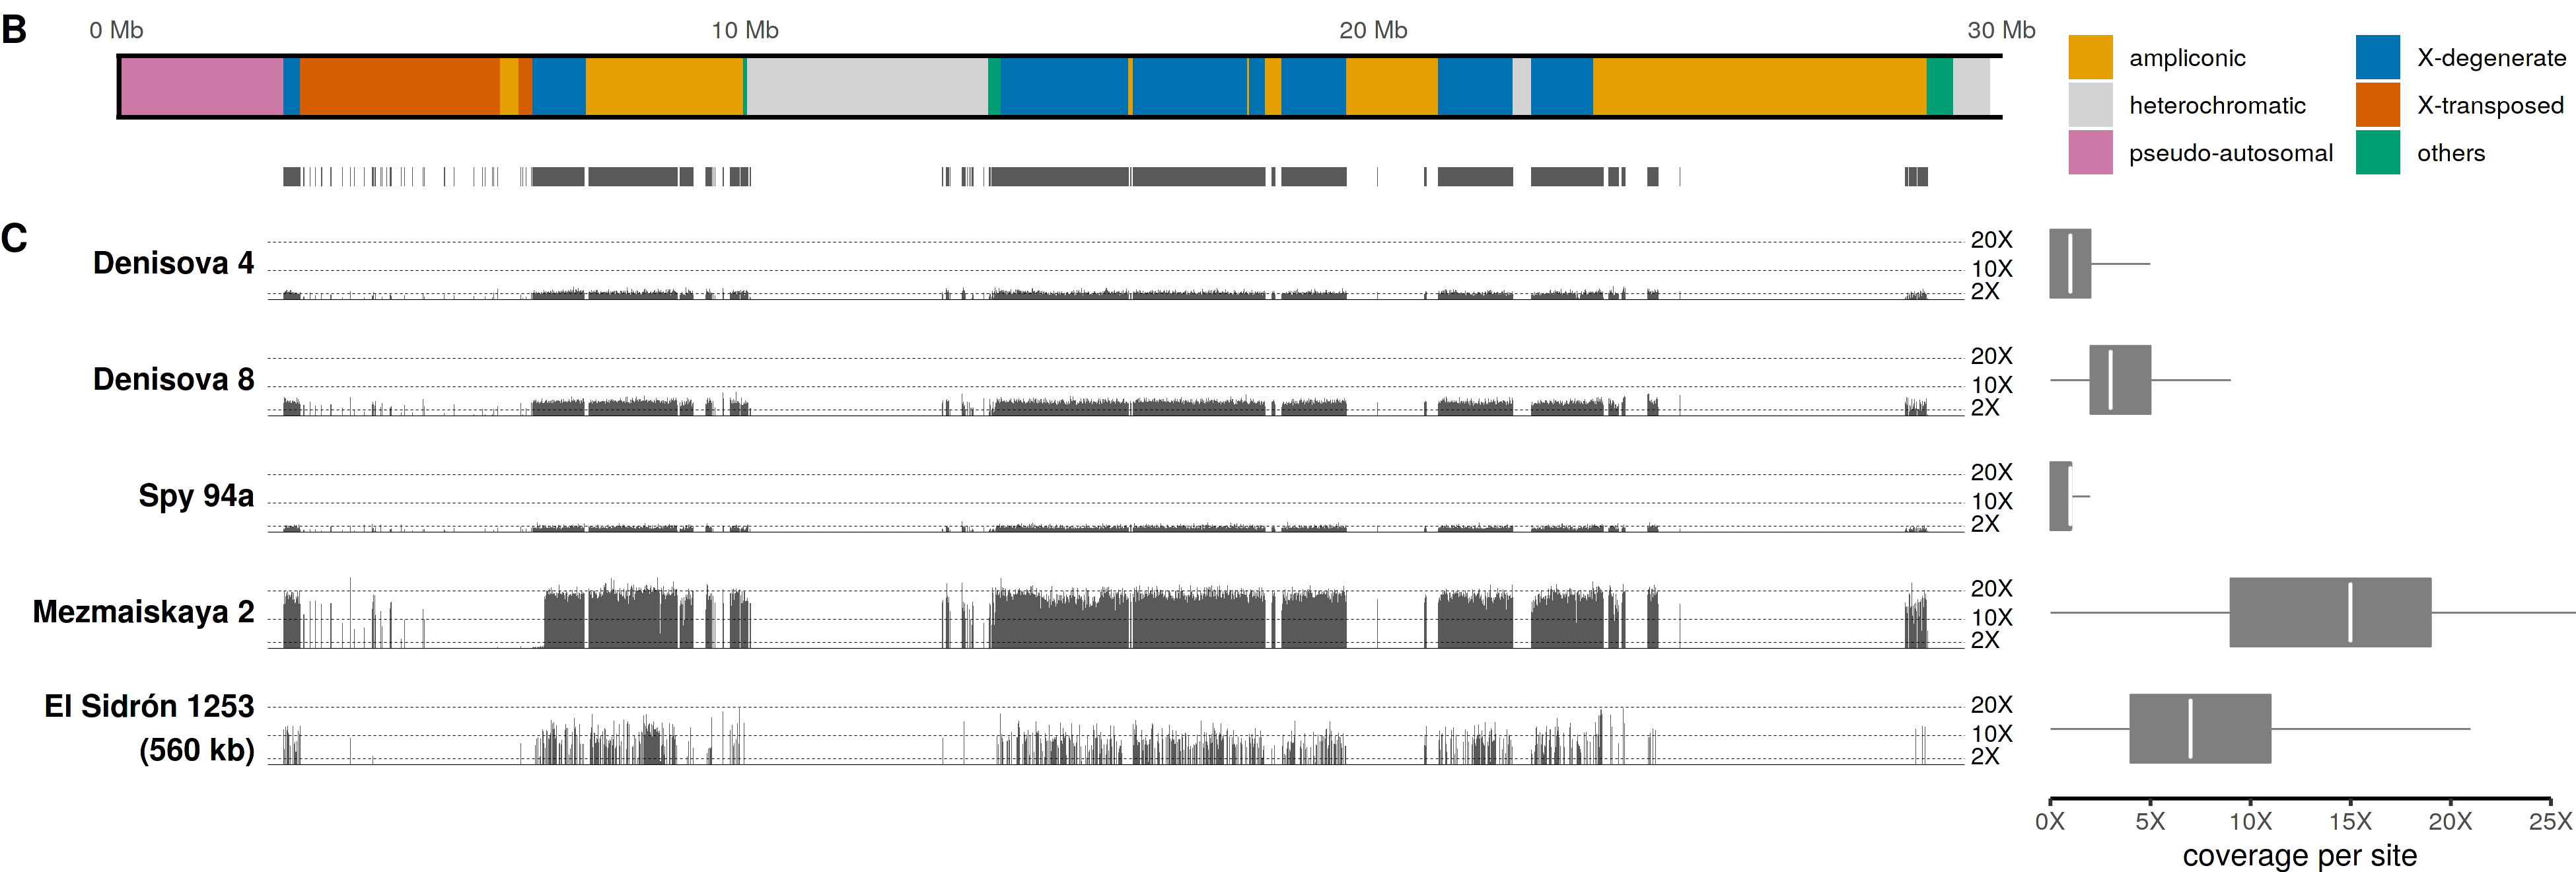

In [33]:
set_dim(13, 4.4)

p_legend <- cowplot::get_legend(p_ychr) %>% ggpubr::as_ggplot() +
    theme(plot.margin = unit(c(0, 0, 0, -0.8), "cm"))

p_combined <- plot_grid(
    plot_grid(p_ychr + theme(legend.position = "none"),
              p_regions,
              p_den4, p_den8, p_spy1, p_mez2, p_elsidron, NULL,
              ncol = 1,
              rel_heights = c(0.13, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.07),
              labels = c("B", "", "C", "", "", "", "", "", ""),
              hjust = "left"),
    plot_grid(p_legend, p_box_den4, p_box_den8, p_box_spy1, p_box_mez2, p_box_elsidron2, p_covaxis,
              ncol = 1,
              rel_heights = c(0.18, 0.1, 0.1, 0.1, 0.1, 0.1, 0.07)),
    ncol = 2,
    rel_widths = c(1, 0.22)
)

p_combined

In [34]:
saveRDS(p_combined, here("data/rds/p_coverage.rds"))

<br><br><br>
## Deaminated reads only

For all of those samples we're dangerously close to not having enough data after filtering.

In [35]:
deam_cov <- map_dfr(c("den4_deam", "den8_deam", "den_merged_deam",
                      "spy1_deam", "mez2_deam"), function(ind) {
    regions_cov(ind, "full", directory = "revisions")
})

den4_deam
98% coverage quantile: 2
den8_deam
98% coverage quantile: 5
den_merged_deam
98% coverage quantile: 5
spy1_deam
98% coverage quantile: 2
mez2_deam
98% coverage quantile: 10


In [36]:
deam_cov %>%
    group_by(name) %>%
    summarise(avg_cov = mean(coverage)) %>%
    arrange(avg_cov) %>%
    mutate(avg_cov = format(avg_cov, digits = 1))

name,avg_cov
<chr>,<chr>
Spy 94a (deam.),0.2
Denisova 4 (deam.),0.2
Denisova 8 (deam.),1.3
"Denisova (merged, deam.)",1.5
Mezmaiskaya 2 (deam.),3.6
